# Deep Learning  


## TP3 : Méthodologie, Expérimentations et Régularisation 

Sylvain Lamprier (sylvain.lamprier@univ-angers.fr)

Supports adaptés de Nicolas Baskiotis (nicolas.baskiotis@sorbonne-univeriste.fr) et Benjamin Piwowarski (benjamin.piwowarski@sorbonne-universite.fr) -- MLIA/ISIR, Sorbonne Université

In [16]:
import torch
from networkx import config
from torch.onnx.symbolic_opset9 import batch_norm

print("La version de torch est : ",torch.__version__)
print("Le calcul GPU est disponible ? ", torch.cuda.is_available())

import numpy as np
import sklearn

## Chargement des données California_Housing et transformation en tensor.
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing() ## chargement des données
data_x = torch.tensor(housing['data'],dtype=torch.float)
data_y = torch.tensor(housing['target'],dtype=torch.float).view(-1)
Xdim = data_x.size(1)




La version de torch est :  2.5.1+cu124
Le calcul GPU est disponible ?  False


# Méthodologie expérimentale et boîte à outils
Pytorch dispose d'un ensemble d'outils qui permettent de simplifier les démarches expérimentales. Nous allons voir en particulier : 
* le DataLoader qui permet de gérer le chargement de données, le partitionement et la constitution d'ensembles de test et d'apprentissage; 
* le checkpointing qui permet de sauvegarder/charger les modèles en cours d'entraînement.
* le TensorBoard (qui vient de tensorflow) qui permet de suivre l'évolution en apprentissage de vos modèles.



## DataLoader
Le <a href=https://pytorch.org/docs/stable/data.html>**DataLoader**</a> et la classe associée <a href=https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset> **Dataset**</a>  permettent en particulier de :
* charger des données
* pré-processer les données
* de gérer les mini-batchs (sous-ensembles sur lequel on effectue une descente de gradient).

La classe **Dataset** est une classe abstraite qui nécessite l'implémentation que d'une seule méthode, ```__getitem__(self,index)``` : elle renvoie le i-ème objet du jeu de données (généralement un couple *(exemple,label)*. 

La classe **TensorDataset** est l'instanciation la plus courante d'un **Dataset**, elle permet de créer un objet **Dataset** à partir d'une liste de tenseurs qui renvoie pour un index $i$ donné le tuple contenant les $i$-èmes ligne de chaque tenseur.

La classe **DataLoader** permet essentiellement de randomiser et de constituer des mini-batchs de façon simple à partir d'une instance de **Dataset**. Chaque mini-batch est constitué d'exemples tirés aléatoirement dans le **Dataset** passé en paramètre et mis bout à bout dans des tenseurs. La méthode ```collate_fn(*args)``` est utilisée pour cela (nous verrons une customization de cette fonction dans une séance ultérieure). C'est ce générateur qui est généralement parcouru lors de l'apprentissage à chaque itération d'optimisation.

Voici un exemple de code pour utiliser le DataLoader : 


In [17]:
from torch.utils.data import DataLoader,TensorDataset, Dataset

## Création d'un dataset à partir des deux tenseurs d'exemples et de labels
train_data = TensorDataset(data_x,data_y)
## On peut indexer et connaitre la longueur d'un dataset
print(len(train_data),train_data[5])

## Création d'un DataLoader
## tailles de mini-batch de 16, shuffle=True permet de mélanger les exemples
# loader est un itérateur sur les mini-batchs des données
loader = DataLoader(train_data, batch_size=16,shuffle=True ) 

#Premier batch (aléatoire) du dataloader :
print(len(iter(loader)),next(iter(loader)))

## Exemple d'un Dataset (sans utilité dans le cas présent, TensorDataset permet de faire la même chose)
class MyDataSet(Dataset):
  def __init__(self, x,y):
    self.x = x
    self.y = y
  def __getitem__(self,i):
    return self.x[i],self.y[i]
  def __len__(self):
    return len(self.x)

20640 (tensor([   4.0368,   52.0000,    4.7617,    1.1036,  413.0000,    2.1399,
          37.8500, -122.2500]), tensor(2.6970))
1290 [tensor([[ 1.7813e+00,  2.9000e+01,  4.6486e+00,  9.1990e-01,  1.2780e+03,
          3.3023e+00,  3.6430e+01, -1.1969e+02],
        [ 6.2712e+00,  4.7000e+01,  6.9491e+00,  1.0291e+00,  6.9700e+02,
          2.5345e+00,  3.7940e+01, -1.2232e+02],
        [ 4.2062e+00,  3.5000e+01,  4.7975e+00,  9.3865e-01,  4.9900e+02,
          3.0613e+00,  3.4090e+01, -1.1793e+02],
        [ 4.1250e+00,  1.9000e+01,  5.3737e+00,  1.0303e+00,  1.3170e+03,
          2.2172e+00,  3.7940e+01, -1.2202e+02],
        [ 7.7382e+00,  3.8000e+01,  5.4823e+00,  1.1062e+00,  1.2510e+03,
          2.1096e+00,  3.4070e+01, -1.1843e+02],
        [ 3.7125e+00,  3.1000e+01,  5.3363e+00,  9.9246e-01,  1.7150e+03,
          2.5867e+00,  3.4160e+01, -1.1726e+02],
        [ 3.9699e+00,  1.4000e+01,  5.3754e+00,  1.0336e+00,  6.3010e+03,
          2.2273e+00,  3.4230e+01, -1.1896e+02],
    

In [ ]:
EPOCHS = 100
EPS=1e-4
netSeq = torch.nn.Sequential(torch.nn.Linear(Xdim,5),torch.nn.Tanh(),torch.nn.Linear(5,1))
optim = torch.optim.Adam(params=netSeq.parameters(),lr=EPS)
mseloss = torch.nn.MSELoss()
# La boucle d'apprentissage :
for i in range(EPOCHS):
    cumloss = 0
    # On parcourt tous les exemples par batch de 16 (paramètre batch_size de DataLoader)
    for bx,by in loader:
        loss = mseloss(netSeq(bx).view(-1),by)
        optim.zero_grad()
        loss.backward()
        optim.step()
        cumloss += loss.item()
    if i % 10==0: print(f"iteration : {i}, loss : {cumloss/len(loader)}")


iteration : 0, loss : 8.44908553759257


## Checkpointing
Les modèles Deep sont généralement long à apprendre. Afin de ne pas perdre des résultats en cours de calcul, il est fortement recommander de faire du **checkpointing**, c'est-à-dire d'enregistrer des points d'étapes du modèle en cours d'apprentissage pour pouvoir reprendre à n'importe quel moment l'apprentissage du modèle en cas de problème.  Il s'agit en pratique de sauvegarder l'état du modèle et de l'optimisateur (et de tout autre objet qui peut servir lors de l'apprentissage) toutes les n itérations. Toutes les variables d'intérêt sont en général disponibles par la méthode **state_dict()** des modèles et de l'optimiseur. 

En pratique, vous pouvez utilisé un code dérivé de celui ci-dessous.




In [4]:
import os
def save_state(epoch,model,optim,fichier):
      """ sauvegarde du modèle et de l'état de l'optimiseur dans fichier """
      state = {'epoch' : epoch, 'model_state': model.state_dict(), 'optim_state': optim.state_dict()}
      torch.save(state,fichier)
 
def load_state(fichier,model,optim):
      """ Si le fichier existe, on charge le modèle et l'optimiseur """
      epoch = 0
      if os.path.isfile(fichier):
          state = torch.load(fichier)
          model.load_state_dict(state['model_state'])
          optim.load_state_dict(state['optim_state'])
          epoch = state['epoch']
      return epoch

fichier = "/tmp/netSeq.pth" 
save_state(EPOCHS,netSeq,optim,fichier)    
    

In [5]:
# On crée un autre réseau similaire à celui sauvegardé et on charge les poids 
# on peut observer qu'on repart du même point que le réseau précédent
netSeq = torch.nn.Sequential(torch.nn.Linear(Xdim,5),torch.nn.Tanh(),torch.nn.Linear(5,1))
optim = torch.optim.Adam(params=netSeq.parameters(),lr=EPS)

start_epoch = load_state(fichier,netSeq,optim)
for epoch in range(start_epoch,start_epoch+EPOCHS):
    cumloss = 0
    for bx,by in loader:
        loss = mseloss(netSeq(bx).view(-1),by)
        optim.zero_grad()
        loss.backward()
        optim.step()
        cumloss += loss.item()
    if epoch % 10 ==0: 
        save_state(epoch,netSeq,optim,fichier)
        print(f"epoch : {epoch}, loss : {cumloss/len(loader)}")

/tmp/ipykernel_42655/475055523.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(fichier)


epoch : 100, loss : 1.3314216262379357
epoch : 110, loss : 1.3314291658789612
epoch : 120, loss : 1.3313745029674944
epoch : 130, loss : 1.3313496572102688
epoch : 140, loss : 1.3312658595946407
epoch : 150, loss : 1.3311576210944227
epoch : 160, loss : 1.3311525393133015
epoch : 170, loss : 1.3311549580836481
epoch : 180, loss : 1.331074503364489
epoch : 190, loss : 1.330887097443721



## GPU 
Afin d'utiliser un GPU lors des calculs, il est nécessaire de transférer les données et le modèle sur le GPU par l'intermédiaire de la fonction **to(device)** des tenseurs et des modules.  Il est impossible de faire une opération lorsqu'une partie des tenseurs sont sur GPU et l'autre sur CPU. Il faut que tous les tenseurs et paramètres soient sur le même device ! On doit donc s'assurer que le modèle, les exemples et les labels sont sur GPU pour faire les opérations.

Par ailleurs, on peut connaître le device sur lequel est chargé un tenseur par l'intermédiaire de ```.device``` (mais pas pour un modèle, il faut aller voir les paramètres dans ce cas).

Une manière simple d'utiliser un GPU quand il existe et donc d'avoir un code agnostique est la suivante : 


In [6]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

loader = DataLoader(TensorDataset(data_x,data_y), batch_size=16,shuffle=True ) 

## On charge le modèle sur GPU
## A faire avant la déclaration de l'optimiseur, sinon les paramètres optimisés ne seront pas les mêmes! 

netSeq = torch.nn.Sequential(torch.nn.Linear(Xdim,5),torch.nn.Tanh(),torch.nn.Linear(5,1))
netSeq = netSeq.to(device)
optim = torch.optim.Adam(params=netSeq.parameters(),lr=EPS)

for i,(bx,by) in enumerate(loader):
    ## On charge le batch sur GPU
    bx, by = bx.to(device), by.to(device)
    loss = mseloss(netSeq(bx).view(-1),by)
    optim.zero_grad()
    loss.backward()
    optim.step()


print("Device du mini-batch : ", bx.device)


Device du mini-batch :  cpu



## TensorBoard

Durant l'apprentissage de vos modèles, il est agréable de visualiser de quelle manière évolue le coût, la précision sur l'ensemble de validation ainsi que d'autres éléments. TensorFlow dispose d'un outil très apprécié, le TensorBoard, qui permet de gérer très facilement de tels affichages. On retrouve tensorboard dans **Pytorch** dans ```torch.utils.tensorboard``` qui permet de faire le pont de pytorch vers cet outil. 

Le principe est le suivant :
* tensorboard fait tourner en fait un serveur web local qui va lire les fichiers de log dans un répertoire local. L'affichage se fait dans votre navigateur à partir d'un lien fourni lors du lancement de tensorboard.
* Les éléments que vous souhaitez visualiser (scalaire, graphes, distributions, histogrammes) sont écrits dans le fichier de log à partir d'un objet **SummaryWriter** .
* la méthode ```add_scalar(tag, valeur, global_step)``` permet de logger une valeur à un step donné, ```add_scalar(tag, tag_scalar_dic, global_step)``` un ensemble de valeurs par l'intermédiaire du dictionnaire ```tag_scalar_dic``` (un regroupement des scalaires est fait en fonction du tag passé, chaque sous-tag séparé par un **/**).

Il existe d'autres méthodes ```add_XXX``` pour visualiser par exemple des images, des histogrammes (cf <a href=https://pytorch.org/docs/stable/tensorboard.html>la doc </a>).

Le code suivant illustre une manière de l'utiliser. 

In [7]:
# Pour observer les courbes produites, il faut lancer tensorboard 
# à la main à partir du shell :  tensorboard --logdir /tmp/logs/deep
TB_PATH = "/tmp/logs/deep"
from torch.utils.tensorboard import SummaryWriter

class DeuxCouches(torch.nn.Module):
  def __init__(self):
    super(DeuxCouches,self).__init__()
    self.un = torch.nn.Linear(Xdim,5)
    self.act = torch.nn.Tanh()
    self.deux = torch.nn.Linear(5,1)
  def forward(self,x):
    return self.deux(self.act(self.un(x)))

EPS = 1e-5
EPOCHS=100
netSeq = torch.nn.Sequential(torch.nn.Linear(Xdim,5),torch.nn.Tanh(),torch.nn.Linear(5,1))
netDeuxCouches = DeuxCouches()
netSeq.name = "Sequentiel"
netDeuxCouches.name = "DeuxCouches"
## Obtention d'un SummaryWriter 
summary = SummaryWriter(f"{TB_PATH}/test")

mseloss = torch.nn.MSELoss()
for model in [netSeq, netDeuxCouches]:
    optim = torch.optim.Adam(params=model.parameters(),lr=EPS) 
    for i in range(EPOCHS):
        cumloss = 0
        for boston_x, boston_y in loader:
            loss = mseloss(model(boston_x),boston_y.view(-1,1))
            optim.zero_grad()
            loss.backward()
            optim.step()  
            cumloss+= loss.item()
        summary.add_scalar(f"loss/{model.name}",cumloss/len(loader),i)
        print(f"epoch : {i}, loss : {cumloss/len(loader)}")


epoch : 0, loss : 5.799375577860101
epoch : 1, loss : 5.487418466667796
epoch : 2, loss : 5.1886165247407074
epoch : 3, loss : 4.902273186694744
epoch : 4, loss : 4.628070184981176
epoch : 5, loss : 4.365507363348968
epoch : 6, loss : 4.114989611298539
epoch : 7, loss : 3.87585249390713
epoch : 8, loss : 3.6482387152291085
epoch : 9, loss : 3.4318542650503705
epoch : 10, loss : 3.2264794360759645
epoch : 11, loss : 3.033013763192088
epoch : 12, loss : 2.850596846397533
epoch : 13, loss : 2.679334432094596
epoch : 14, loss : 2.519628061666045
epoch : 15, loss : 2.370890045420144
epoch : 16, loss : 2.233030836596045
epoch : 17, loss : 2.1061494263567666
epoch : 18, loss : 1.9907217646638553
epoch : 19, loss : 1.8857101055425267
epoch : 20, loss : 1.7909961455783179
epoch : 21, loss : 1.7067061338775842
epoch : 22, loss : 1.6328243989699571
epoch : 23, loss : 1.5691422272675721
epoch : 24, loss : 1.515131795822188
epoch : 25, loss : 1.4698175875137942
epoch : 26, loss : 1.4331821091877397

# Visualisation des courbes dans tensorboard
![Capture du tensorboard](./img/tensorBoard1.png)

## Dernières remarques et exemple typique de code
* Le graphe de calcul est instancié de manière dynamique sous pytorch, et cela consomme des ressources. Lorsqu'il n'y a pas de rétropropagation qui intervient - lors de l'évaluation d'un modèle par exemple -, il faut à tout prix éviter de le calculer. L'environnement **torch.no_grad()** permet de désactiver temporairement l'instanciation du graphe. **Toutes les procédures d'évaluation doivent se faire dans cet environnement afin d'économiser du temps !**
* Pour certains modules, le comportement est différent entre l'évaluation et l'apprentissage (pour le dropout ou la batchnormalisation par exemple, ou pour les RNNs). Afin d'indiquer à pytorch dans quelle phase on se situe, deux méthodes sont disponibles dans la classe module,  **.train()** et **.eval()** qui permettent de basculer entre les deux environnements.

Les deux fonctionalités sont très différentes : **no_grad** agit au niveau du graphe de calcul et désactive sa construction (comme si les variables avaient leur propriété **requires_grad** à False), alors que **eval/train** agissent au niveau du module et influence le comportement du module.

Vous trouverez ci-dessous un exemple typique de code pytorch qui reprend l'ensemble des éléments de ce tutoriel. Vous êtes prêt maintenant à expérimenter la puissance de ce framework.

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import time
import os
TB_PATH = "/tmp/logs/module1"
MODEL_PATH = "/tmp/models"
os.makedirs(MODEL_PATH,exist_ok=True)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")


In [9]:
def save_state(fichier,epoch,model,optim):
    state = {'epoch' : epoch, 'model_state': model.state_dict(), 'optim_state': optim.state_dict()}
    torch.save(state,fichier)

def load_state(fichier,model,optim):
    epoch = 0
    if os.path.isfile(fichier):
        state = torch.load(fichier)
        model.load_state_dict(state['model_state'])
        optim.load_state_dict(state['optim_state'])
        epoch = state['epoch']
    return epoch


def train(model, loss, epochs, train_loader, test_loader,lr=1e-3):
    # On créé un writer avec la date du modèle pour s'y retrouver
    check_file = f"{MODEL_PATH}/{model.name}.pth"
    summary = SummaryWriter(f"{TB_PATH}/{model.name}")
    optim = torch.optim.Adam(params=model.parameters(),lr=lr)
    start_epoch = load_state(check_file,model,optim)
    for epoch in range(start_epoch,epochs):
        # Apprentissage
        # .train() inutile tant qu'on utilise pas de normalisation ou de récurrent
        model.train()
        cumloss = 0
        for xbatch, ybatch in train_loader:
            xbatch, ybatch = xbatch.to(device), ybatch.to(device)
            outputs = model(xbatch)
            l = loss(outputs.view(-1),ybatch)
            optim.zero_grad()
            l.backward()
            optim.step()
            cumloss += l.item()
        summary.add_scalar("loss/train",  cumloss/len(train_loader),epoch)
        print(f"epoch : {epoch}, loss : {cumloss/len(train_loader)}")
        
        if epoch % 10 == 0: 
            save_state(check_file,epoch,model,optim)
            # Validation
            # .eval() inutile tant qu'on utilise pas de normalisation ou de récurrent
            net.eval()
            with torch.no_grad():
                cumloss = 0
                for xbatch, ybatch in test_loader:
                    xbatch, ybatch = xbatch.to(device), ybatch.to(device)
                    outputs = model(xbatch)
                    cumloss += loss(outputs.view(-1),ybatch).item()
            summary.add_scalar("loss/validation", cumloss/len(test_loader) ,epoch)
            print(f"epoch validation: {epoch}, loss : {cumloss/len(test_loader)}")
        

In [10]:
from datetime import datetime
# Datasets
from sklearn.datasets import fetch_california_housing
housing = fetch_california_housing() ## chargement des données
all_data = torch.tensor(housing['data'],dtype=torch.float)
all_labels = torch.tensor(housing['target'],dtype=torch.float).view(-1)

# Il est toujours bon de normaliser
all_data = (all_data-all_data.mean(0))/all_data.std(0)
all_labels = (all_labels-all_labels.mean())/all_labels.std()

train_tensor_data = TensorDataset(all_data, all_labels)

# Split en 80% apprentissage et 20% test
train_size = int(0.8 * len(train_tensor_data))
validate_size = len(train_tensor_data) - train_size
train_data, valid_data = torch.utils.data.random_split(train_tensor_data, [train_size, validate_size])


EPOCHS = 100
BATCH_SIZE = 16

train_loader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=BATCH_SIZE)

net = torch.nn.Sequential(torch.nn.Linear(all_data.size(1),5),torch.nn.Tanh(),torch.nn.Linear(5,1))
net.name = "mon_premier_reseau_" + datetime.now().strftime("%Y%m%d_%H%M%S")

net = net.to(device)
train(net,torch.nn.MSELoss(),EPOCHS,train_loader,valid_loader,lr=1e-5)


epoch : 0, loss : 1.2535664746321218
epoch validation: 0, loss : 1.236368711027064
epoch : 1, loss : 1.22589987990006
epoch : 2, loss : 1.1996882099282833
epoch : 3, loss : 1.1744747397800286
epoch : 4, loss : 1.1498940571449523
epoch : 5, loss : 1.1259144559906897
epoch : 6, loss : 1.1025981295189655
epoch : 7, loss : 1.0800588135571443
epoch : 8, loss : 1.0581529892172463
epoch : 9, loss : 1.036910327194735
epoch : 10, loss : 1.016422776086617
epoch validation: 10, loss : 0.9993881801533144
epoch : 11, loss : 0.9966348245913206
epoch : 12, loss : 0.9773591482477595
epoch : 13, loss : 0.9587463360539702
epoch : 14, loss : 0.9406913151285907
epoch : 15, loss : 0.923165406425332
epoch : 16, loss : 0.9061997810941796
epoch : 17, loss : 0.8897338026282631
epoch : 18, loss : 0.8737144703262074
epoch : 19, loss : 0.8581577244019786
epoch : 20, loss : 0.842925636776427
epoch validation: 20, loss : 0.8279010540870733
epoch : 21, loss : 0.8280285736329334
epoch : 22, loss : 0.8134475855893174


# Expérimentations
## Jeu de données MNIST
Ce jeu de données est l'équivalent du *Hello world* en programmation. Chaque donnée est un chiffre manuscrit (de 0 à 9). Les lignes suivantes vous permettent de charger le jeu de données.


In [11]:
import numpy as np
# deux couches caché de 100 neurones pour avoir le suraprentissage
# l2 marche pas de ouf par contre dropout efficace
# Modules (torch, nn, F et optim)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data
import torchvision.datasets as dset
import torchvision.utils as vutils
import torch.backends.cudnn as cudnn
from torch.nn.functional import one_hot
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# Progrès
from tqdm import tqdm
from tqdm.autonotebook import tqdm
#from tqdm import tqdm_notebook as tqdm

#matpotlib 
import matplotlib
import matplotlib.pyplot as plt


import time
import os
from tensorboard import notebook


TB_PATH = "/tmp/logs/deep_tp3"
from torch.utils.tensorboard import SummaryWriter


mean=[0.5]
std=[0.5]
batchsize=128

#Transformations à appliquer sur le dataset (transformation des images en tenseurs et normalization pour obtenir des valeurs entre -1 et 1)
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)])

# Téléchargement des données (via le dataset specifique MNIST de pytorch)
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
print(len(trainset))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, pin_memory=True, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchsize, pin_memory=True, shuffle=False)




/tmp/ipykernel_42655/219069740.py:20: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


60000


## Visualisation d'une image


torch.Size([128, 1, 28, 28])


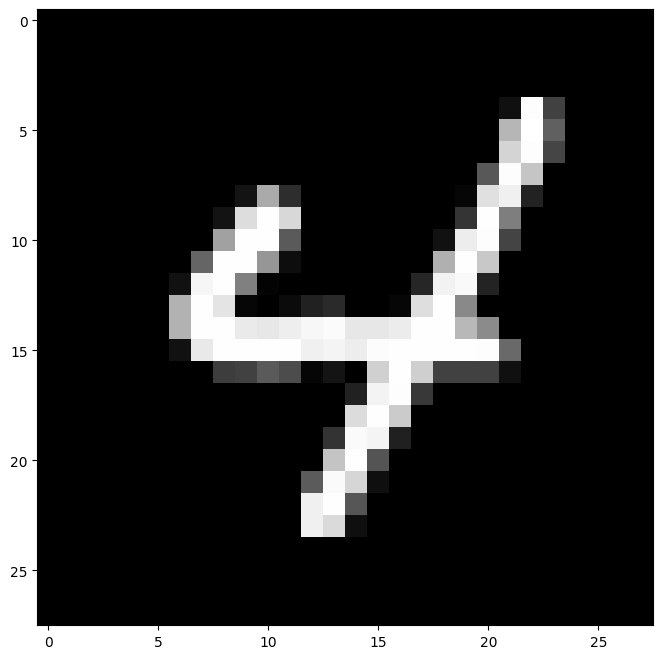

In [12]:
def unnormalize(img):
  if img.dim()==2 or ((img.dim()==3) and (img.size()[0]==1)):
      return img*std[0]+mean[0]
  return img * img.new(std).view(3, 1, 1) + img.new(mean).view(3, 1, 1)

# Recuperation du premier batch
imgs,labs=next(iter(trainloader))
# dimension of images (flattened)
HEIGHT,WIDTH = imgs.shape[2],imgs.shape[3] # taille de l'image

INPUT_DIM = HEIGHT * WIDTH

#Visualisation de la première image
print(imgs.size())
img = unnormalize(imgs[0]) # pour retrouver l'image d'origine (avant normalisation)
fig=plt.figure(figsize=(8, 8))
plt.imshow(img.squeeze(),cmap='Greys_r')

In [13]:

from torch.utils.data import DataLoader,TensorDataset, Dataset

## On utilise qu'une partie du training test pour mettre en évidence le sur-apprentissage
TRAIN_RATIO = 0.01
train_length = int(len(trainset)*TRAIN_RATIO)

ds_train, ds_test =  torch.utils.data.random_split(trainset, (train_length, len(trainset)- train_length))

#On utilise un DataLoader pour faciliter les manipulations, on fixe  la taille du mini batch à 300
train_loader = DataLoader(ds_train,batch_size=300,shuffle=True)
test_loader = DataLoader(ds_test,batch_size=300,shuffle=False)

print(next(iter(train_loader)))
def accuracy(yhat,y):
    # y encode les indexes, s'assurer de la bonne taille de tenseur
    assert len(y.shape)==1 or y.size(1)==1
    return (torch.argmax(yhat,1).view(y.size(0),-1)== y.view(-1,1)).double().mean()

[tensor([[[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          ...,
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.],
          [-1., -1., -1.,  ..., -1., -1., -1.]]],


        ...,


        [[[-1., -1., -1.,  ..., -1., -1., -1.],
          [-1.,

##  <span class="alert-success"> Exercice : Classification multi-labels, nombre de couches, fonction de coût </span>

L'objectif est de classer chaque image parmi les 10 chiffres qu'ils représentent. Le réseau aura donc 10 sorties, une par classe, chacune représentant la probabilité d'appartenance à chaque classe. Pour garantir une distribution de probabilité en sortie, il faut utiliser le module <a href=https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html> **Softmax** </a> : $$\texttt{Softmax}(\mathbf{x})_i = \frac{e^{x_i}}{\sum_{j=1}^d x_j}$$ qui permet de normaliser le vecteur de sortie.

* Faites quelques exemples de réseau à 1, 2, 3 couches et en faisant varier les nombre de neurones par couche. Utilisez un coût moindre carré dans un premier temps. Pour superviser ce coût, on doit construire le vecteur one-hot correspondant à la classe : un vecteur qui ne contient que des 0 sauf à l'index de la classe qui contient un 1 (utilisez ```torch.nn.functional.one_hot```).  Comparez les courbes de coût et d'erreurs en apprentissage et en test selon l'architecture.
* Le coût privilégié en multi-classe est la *cross-entropy**. Ce coût représente la négative log-vraisemblance : $$NNL(y,\mathbf{x}) = -x_{y} $$ en notant $y$ l'indice de la classe et $\mathbf{x}$ le vecteur de log-probabilité inféré. On peut utiliser soit son implémentation par le module <a href=https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss>**NLLLoss**</a>, soit - plus pratique - le module <a href=https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html>**CrossEntropyLoss** <a>  qui combine un *logSoftmax* et la cross entropie, ce qui évite d'avoir à ajouter un module de *Softmax* en sortie du réseau. Utilisez ce dernier coût et observez les changements.
* Changez la fonction d'activation en une ReLU et observez l'effet.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

# Fonction d'accuracy
def accuracy(yhat, y):
    assert len(y.shape) == 1 or y.size(1) == 1
    return (torch.argmax(yhat, dim=1) == y).double().mean()

# Fonction pour convertir en one-hot
def to_one_hot(y, num_classes):
    return F.one_hot(y, num_classes=num_classes).float()

def train_and_log(model, train_loader, test_loader, criterion, optimizer, epochs, writer, output_dim):
    for epoch in range(epochs):
        # Mode entraînement
        model.train()
        train_loss, train_acc = 0, 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            
            # Aplatir les données si nécessaire
            x_batch = x_batch.view(x_batch.size(0), -1)
            
            yhat = model(x_batch)

            # Si on utilise MSELoss, convertir les cibles en one-hot
            if isinstance(criterion, nn.MSELoss):
                y_batch = to_one_hot(y_batch, num_classes=output_dim)
            
            loss = criterion(yhat, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc += accuracy(yhat, y_batch if isinstance(criterion, nn.CrossEntropyLoss) else torch.argmax(y_batch, dim=1)).item()

        train_loss /= len(train_loader)
        train_acc /= len(train_loader)

        # Mode évaluation - toutes les 50 époques
        if (epoch + 1) % 50 == 0 or epoch == epochs - 1 or epoch == 0:
            model.eval()  # Activer le mode évaluation (Dropout désactivé)
            test_loss, test_acc = 0, 0
            with torch.no_grad():
                for x_batch, y_batch in test_loader:
                    x_batch, y_batch = x_batch.to(device), y_batch.to(device)

                    # Aplatir les données si nécessaire
                    x_batch = x_batch.view(x_batch.size(0), -1)

                    yhat = model(x_batch)

                    # Si on utilise MSELoss, convertir les cibles en one-hot
                    if isinstance(criterion, nn.MSELoss):
                        y_batch = to_one_hot(y_batch, num_classes=output_dim)

                    loss = criterion(yhat, y_batch)

                    test_loss += loss.item()
                    test_acc += accuracy(yhat, y_batch if isinstance(criterion, nn.CrossEntropyLoss) else torch.argmax(y_batch, dim=1)).item()

            test_loss /= len(test_loader)
            test_acc /= len(test_loader)
            print(f"Epoch {epoch+1}/{epochs} -> Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

            # Enregistrement dans TensorBoard
            writer.add_scalars("Loss", {"Train": train_loss, "Test": test_loss}, epoch)
            writer.add_scalars("Accuracy", {"Train": train_acc, "Test": test_acc}, epoch)


# Classe LinearMultiClass avec ajout de Dropout
class LinearMultiClass(nn.Module):
    def __init__(self, inSize, outSize, layers=None, finalActivation=None, activation=nn.Tanh, dropout_prob=0):
        super(LinearMultiClass, self).__init__()
        
        if layers is None:
            layers = []

        self.layers = nn.ModuleList()  # Utilisé pour accéder aux modules individuels
        input_dim = inSize

        # Ajouter les couches cachées
        for hidden_dim in layers:
            self.layers.append(nn.Linear(input_dim, hidden_dim))
            self.layers.append(activation())
            self.layers.append(nn.Dropout(p=dropout_prob))  # Ajouter Dropout après chaque activation
            input_dim = hidden_dim

        # Ajouter la couche de sortie
        self.layers.append(nn.Linear(input_dim, outSize))

        # Ajouter la fonction d'activation finale si elle est définie
        if finalActivation is not None:
            self.layers.append(finalActivation)

        # Utilisation de nn.Sequential pour empiler les couches
        self.model = nn.Sequential(*self.layers)
        
    def forward(self, x):
        return self.model(x)


# Comparaison des modèles
def compare_models(train_loader, test_loader, input_dim, output_dim, epochs=2000):
    # Configurations à comparer
    configs = [
        {"activation": nn.Tanh, "criterion": nn.MSELoss(), "tag": "Tanh_MSE"},
        {"activation": nn.Tanh, "criterion": nn.CrossEntropyLoss(), "tag": "Tanh_CrossEntropy"},
        {"activation": nn.ReLU, "criterion": nn.CrossEntropyLoss(), "tag": "ReLU_CrossEntropy"},
        {"activation": nn.ReLU, "criterion": nn.MSELoss(), "tag": "ReLU_MSE"},
    ]
    
    for config in configs:
        # Utiliser Softmax comme finalActivation seulement si on utilise CrossEntropyLoss
        final_activation = None if isinstance(config["criterion"], nn.CrossEntropyLoss) else nn.Softmax(dim=1)

        # Initialisation du modèle
        model = LinearMultiClass(
            inSize=input_dim,
            outSize=output_dim,
            layers=[100,100],
            finalActivation=final_activation,
            activation=config["activation"]
        )

        model = model.to(device)
        
        # Initialisation de l'optimiseur et du critère
        optimizer = torch.optim.Adam(model.parameters())
        criterion = config["criterion"]
        
        # TensorBoard Writer
        writer = SummaryWriter(log_dir=f"runs/{config['tag']}")
        
        print(f"\nTraining configuration: {config['tag']}")
        
        # Entraînement
        train_and_log(model, train_loader, test_loader, criterion, optimizer, epochs, writer, output_dim)
        
        writer.close()

# Paramètres du dataset et de l'entraînement
input_dim = train_loader.dataset[0][0].numel()
output_dim = 10  # Nombre de classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

compare_models(train_loader, test_loader, input_dim, output_dim, epochs=2000)



Training configuration: Tanh_MSE
Epoch 1/2000 -> Train Loss: 0.0899, Train Acc: 0.1717, Test Loss: 0.0889, Test Acc: 0.1126
Epoch 50/2000 -> Train Loss: 0.0012, Train Acc: 0.9967, Test Loss: 0.0204, Test Acc: 0.8594
Epoch 100/2000 -> Train Loss: 0.0003, Train Acc: 0.9983, Test Loss: 0.0204, Test Acc: 0.8601
Epoch 150/2000 -> Train Loss: 0.0001, Train Acc: 1.0000, Test Loss: 0.0204, Test Acc: 0.8607
Epoch 200/2000 -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0206, Test Acc: 0.8596
Epoch 250/2000 -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0208, Test Acc: 0.8596
Epoch 300/2000 -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0209, Test Acc: 0.8595
Epoch 350/2000 -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0209, Test Acc: 0.8593
Epoch 400/2000 -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0210, Test Acc: 0.8593
Epoch 450/2000 -> Train Loss: 0.0000, Train Acc: 1.0000, Test Loss: 0.0211, Test Acc: 0.8592
Epoch 500/2000 -> Train Loss: 0.0000, T

## Visualisation des résultats dans TensorBoard
### Relu
#### CrossEntropy
![Accuracy](./img/accuracy_relu_cross.png)
![Loss](./img/loss_relu_cross.png)

![Accuracy](./img/accuracy_relu_mse.png)
![Loss](./img/loss_relu_mse.png)

### Tanh
#### CrossEntropy
![Accuracy](./img/acccuracy_than_cross.png)
![Loss](./img/loss_than_cross.png)

#### MSELoss
![Accuracy](./img/accuracy_than_mse.png)
![Loss](./img/loss_than_mse.png)


## <span class="alert-danger"> On observe du sur-apprentissage avec un ecart d'un 15aine de pourcent entre le train et le test pour l'accuracy et une loss qui remonte en test après un certain nombre d'époque pour les modèles CrossEntropy. </span>

##  <span class="alert-success"> Exercice : Régularisation des réseaux </span>

### Pénalisation des couches
Une première technique pour éviter le sur-apprentissage est de régulariser chaque couche par une pénalisation sur les poids, i.e. de favoriser des poids faibles. On parle de pénalisation L1 lorsque la pénalité est de la forme $\|W\|_1$ et L2 lorsque la norme L2 est utilisée : $\|W\|_2^2$. En pratique, cela consiste à rajouter à la fonction de coût globale du réseau un terme en $\lambda Pen(W)$ pour les paramètres de chaque couche que l'on veut régulariser.

Expérimentez avec une norme L2 dans $\{0,10^{-5},10^{-4},10^{-3},10^{-2},\}$, l'évolution de la pénalisation et du coût en fonction du nombre d'époques. Vous pouvez aussi observer les histogrammes de la distribution des poids des différentes couches en utilisant la fonction addWeightsHisto ci dessous.  Utilisez pour ces experiences un réseau à 3 couches chacune de taille 100 et un coût de CrossEntropy.


In [ ]:
# requiert que les modules soient enregistrés dans une liste model.layers
def addWeightsHisto(writer,model,epoch):                
    ix = 0
    for module in model.layers:
        if isinstance(module, nn.Linear):
           writer.add_histogram(f'linear/{ix}/weight',module.weight, epoch)
           ix += 1

# Comparaison des modèles avec régularisation L2
def compare_models_with_regularization(train_loader, test_loader, input_dim, output_dim, epochs=2000):
    # Liste des valeurs de régularisation L2 à tester
    lambdas = [0, 1e-5, 1e-4, 1e-3, 1e-2]
    config = {"activation": nn.Tanh, "criterion": nn.CrossEntropyLoss(), "tag": "Tanh_CrossEntropy"}
    
    for l2_penalty in lambdas:
        # Initialisation du modèle
        model = LinearMultiClass(
            inSize=input_dim,
            outSize=output_dim,
            layers=[100,100],  # Quatre couches cachées pour la complexité
            finalActivation=nn.Softmax(dim=1),  # Softmax pour la classification multi-classe
            activation=config["activation"]
        )

        model = model.to(device)
        
        # Initialisation de l'optimiseur avec pénalisation L2 (weight_decay)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=l2_penalty)
        criterion = config["criterion"]
        
        # TensorBoard Writer pour visualisation
        writer = SummaryWriter(log_dir=f"runs/{config['tag']}_weight_decay_{l2_penalty}")
        
        print(f"\nTraining configuration: {config['tag']}, L2 Penalty: {l2_penalty}")
        
        # Entraînement du modèle et journalisation
        train_and_log(model, train_loader, test_loader, criterion, optimizer, epochs, writer, output_dim)
        
        writer.close()

# Paramètres du dataset et de l'entraînement
input_dim = train_loader.dataset[0][0].numel()
output_dim = 10  # Nombre de classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Comparaison des modèles avec différentes régularisations L2
compare_models_with_regularization(train_loader, test_loader, input_dim, output_dim, epochs=2000)
    
    
    
    

## Visualisation des résultats dans TensorBoard
### Penalité 0
![Accuracy](./img/penality0.png)

### Penalité 1e-5
![Accuracy](./img/penality1e-5.png)

### Penalité 1e-4
![Accuracy](./img/penality1e-4.png)

### Penalité 1e-3
![Accuracy](./img/penality1e-3.png)

### Penalité 1e-2
![Accuracy](./img/penality1e-2.png)

### Dropout

Une autre technique très utilisée est le <a href=https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html> **Dropout** </a>. L’idée du Dropout est proche du moyennage de modèle : en entraînant k modèles de manière indépendante, on réduit la variance du modèle. Entraîner k modèles présente un surcoût non négligeable, et l’intérêt du Dropout est de réduire la complexité mémoire/temps de calcul. Le Dropout consiste à chaque itération à *geler* certains neurones aléatoirement dans le réseau en fixant leur sortie à zéro. Cela a pour conséquence de rendre plus robuste le réseau.

Le comportement du réseau est donc différent en apprentissage et en inférence. Il est obligatoire d'utiliser ```model.train()``` et ```model.eval()``` pour différencier les comportements.
Testez sur quelques réseaux pour voir l'effet du dropout.

In [ ]:
# Comparaison des modèles avec différentes probabilités de Dropout
def compare_models_with_dropout(train_loader, test_loader, input_dim, output_dim, epochs=30):
    # Liste des probabilités de Dropout à tester
    dropout_probs = [0, 0.1, 0.3, 0.5]
    config = {"activation": nn.Tanh, "criterion": nn.CrossEntropyLoss(), "tag": "Tanh_CrossEntropy"}
    
    for dropout_prob in dropout_probs:
        # Initialisation du modèle
        model = LinearMultiClass(
            inSize=input_dim,
            outSize=output_dim,
            layers=[100,100],  # Quatre couches cachées pour la complexité
            finalActivation=nn.Softmax(dim=1),  # Softmax pour la classification multi-classe
            activation=config["activation"],
            dropout_prob=dropout_prob
        )

        model = model.to(device)
        
        # Initialisation de l'optimiseur
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        criterion = config["criterion"]
        
        # TensorBoard Writer pour visualisation
        writer = SummaryWriter(log_dir=f"runs/{config['tag']}_dropout_{dropout_prob}")
        
        print(f"\nTraining configuration: {config['tag']}, Dropout Probability: {dropout_prob}")
        
        # Entraînement du modèle et journalisation
        train_and_log(model, train_loader, test_loader, criterion, optimizer, epochs, writer, output_dim)
        
        writer.close()

# Paramètres du dataset et de l'entraînement
input_dim = train_loader.dataset[0][0].numel()
output_dim = 10  # Nombre de classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Comparaison des modèles avec différentes probabilités de Dropout
compare_models_with_dropout(train_loader, test_loader, input_dim, output_dim, epochs=2000)


## Visualisation des résultats dans TensorBoard
### Dropout 0
![Accuracy](./img/dropout0.png)

### Dropout 0.1
![Accuracy](./img/dropout0.1.png)

### Dropout 0.3
![Accuracy](./img/dropout0.3.png)

### Dropout 0.5
![Accuracy](./img/dropout0.5.png)

### BatchNorm

On sait que les données centrées réduites permettent un apprentissage plus rapide et stable d’un modèle ; bien qu’on puisse faire en sorte que les données en entrées soient centrées réduites, cela est plus délicat pour les couches internes d’un réseau de neurones. La technique de <a href=https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html> **BatchNorm**</a> consiste à ajouter une couche qui a pour but de centrer/réduire les données en utilisant une moyenne/variance glissante (en inférence) et les statistiques du batch (en
apprentissage).

Tout comme pour le dropout, il est nécessaire d'utiliser ```model.train()``` et ```model.eval()```. 
Expérimentez la batchnorm. 

In [ ]:
# Comparaison des modèles avec BatchNorm
def compare_models_with_batchnorm(train_loader, test_loader, input_dim, output_dim, epochs=2000):
    # Liste des probabilités de Dropout à tester
    dropout_probs = [0, 0.1, 0.3, 0.5]
    config = {"activation": nn.Tanh, "criterion": nn.CrossEntropyLoss(), "tag": "Tanh_CrossEntropy_BatchNorm"}
    model = LinearMultiClass(
        inSize=input_dim,
        outSize=output_dim,
        layers=[100,100],  
        finalActivation=nn.Softmax(dim=1), 
        activation=config["activation"],
        BatchNorm=True
    )
    
    model = model.to(device)
    
    # Initialisation de l'optimiseur
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    # TensorBoard Writer pour visualisation
    writer = SummaryWriter(log_dir=f"runs/{config['tag']}")
    
    print(f"\nTraining configuration: {config['tag']}")
    
    # Entraînement du modèle et journalisation
    train_and_log(model, train_loader, test_loader, config["criterion"], optimizer, epochs, writer, output_dim)
    
    writer.close()
        
        
input_dim = train_loader.dataset[0][0].numel()
output_dim = 10  # Nombre de classes
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Comparaison des modèles avec différentes probabilités de Dropout
compare_models_with_batchnorm(train_loader, test_loader, input_dim, output_dim, epochs=2000)
    
    


## Visualisation des résultats dans TensorBoard
### BatchNorm
![Accuracy](./img/batchnorm.png)